## PUBG Modelling

플레이어들이 전장에서 벌이는 모든 행위를 분류하여 승리를 예측하기 위한 프로젝트

## Column 별 정보
- ASSISTS : 자신에 의해 사살되지는 못했지만 자신의 데미지 지분율이 가장 높은 적의 수
- BOOSTS : 도핑 아이템 사용 횟수(에너지 드링크, 진통제, 아드레날린 주사기)
- DAMAGEDEALT : 적에게 가한 전체 데미지
- DBNOS : 기절시킨 적의 수
- GROUPID : 경기 내 그룹 식별 ID
- HEADSHOTKILLS : 헤드샷으로 죽인 적의 수
- HEALS : 회복 아이템 사용 횟수(붕대, 구급상자, 의료용 키트)
- ID : 해당 데이터 ID
- KILLPLACE : 경기 내 적을 죽인 적 수의 순위
- KILLPOINTS : 유저의 ELO레이팅(죽인 적 수 기반)
- KILLS : 경기 내 적을 죽인 수
- KILLSTREAKS : 짧은 시간 내에 연속으로 적을 죽인 수
- LONGESTKILL : 사살한 적까지의 거리의 최대값
- MATCHDURATION : 경기가 진행된 시간(단위:초)
- MATCHID : 경기 식별 ID
- MATCHTYPE : 경기 모드( ex: 솔로, 듀오, 스쿼드 )
- MAXPLACE : 경기 내 총 인원 수
- NUMGROUP : 경기 내 실제 참여 인원 수
- RANKPOINTS : 유저의 ELO 레이팅
- REVIVES : 유저가 팀원을 부활시킨 횟수
- RIDEDISTANCE : 이동수단을 통해 이동한 거리(단위:m)
- ROADKILLS : 이동수단으로 살해한 적의 수
- SWIMDISTANCE : 수영으로 이동한 거리(단위:m)
- TEAMKILLS : 같은 팀원을 살해한 수
- VEHICLEDESTROYS : 파괴한 이동수단의 수
- WALKDISTANCE : 도보로 이동한 거리(단위:m)
- WEAPONSACQUIRED : 획득한 무기의 수
- WINPOINTS : 유저의 ELO 레이팅(승리 횟수 기반)
- WINPLACEPERC : 현재 경기에서의 백분위 기반 유저의 순위(종속변수)

## 라이브러리 및 데이터 불러오기

In [1]:
# 데이터 분석
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 학습을 위한 라이브러리 세팅
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import LinearRegression   # 1. Linear Regression
from sklearn.linear_model import Lasso              # 2. Lasso
from sklearn.linear_model import Ridge              # 3. Ridge
from xgboost.sklearn import XGBRegressor            # 4. XGBoost
from lightgbm.sklearn import LGBMRegressor          # 5. LightGBM

from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold
from functools import partial

import scipy as sp
from scipy import stats
import sys
import warnings                      
warnings.filterwarnings("ignore")
import os
import gc
print(os.listdir("./data/pubg-finish-placement-prediction/"))

['test_V2.csv', 'sample_submission_V2.csv', 'train_V2.csv']


## 전처리

In [41]:
train = pd.read_csv("./data/pubg-finish-placement-prediction/train_V2.csv")
test = pd.read_csv("./data/pubg-finish-placement-prediction/test_V2.csv")
submission = pd.read_csv("./data/pubg-finish-placement-prediction/sample_submission_V2.csv")

In [42]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
gc.collect()

2038

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [44]:
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [45]:
train = train.dropna(axis=0)

### 상관관계와 다중공선성 확인

#### 상관관계(Correlation)

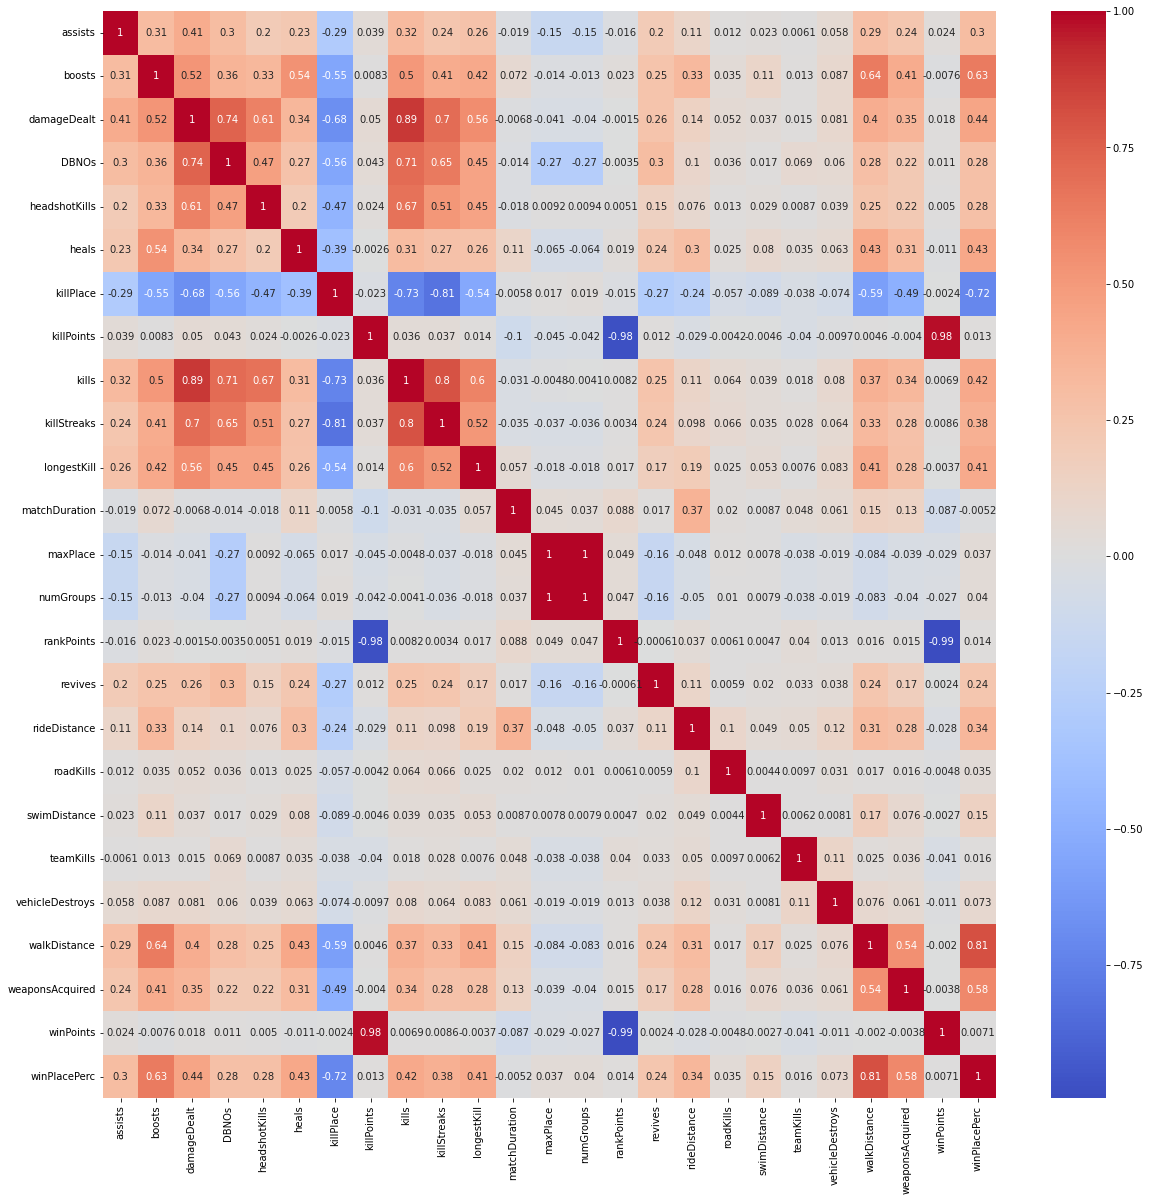

In [7]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)
plt.show()

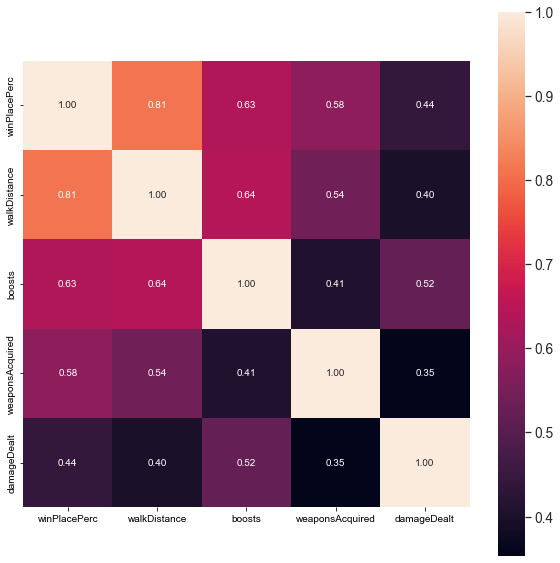

In [8]:
f,ax = plt.subplots(figsize=(10, 10))
cols = train.corr().nlargest(5, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [9]:
df_corr = train.corr()
df_corr = df_corr.apply(lambda x: round(x ,2))
df_corr = df_corr.unstack()
df_corr = pd.DataFrame(df_corr.winPlacePerc[df_corr.winPlacePerc < 1].sort_values(ascending=False), columns=['corr'])
df_corr.style.background_gradient(cmap='viridis')

,corr
walkDistance,0.810000
boosts,0.630000
weaponsAcquired,0.580000
damageDealt,0.440000
heals,0.430000
kills,0.420000
longestKill,0.410000
killStreaks,0.380000
rideDistance,0.340000
assists,0.300000


In [10]:
for i in ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired','winPoints']:
    features, target = train[[i]], train["winPlacePerc"]
    train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.3, random_state=1)
    model = LinearRegression().fit(features, target)
    pred = model.predict(features)
    mae = mean_absolute_error(pred, target)
    print(f'{i} column', np.round(mae, 3))

assists column 0.253
boosts column 0.198
damageDealt column 0.236
DBNOs column 0.255
headshotKills column 0.255
heals column 0.237
killPlace column 0.165
killPoints column 0.268
kills column 0.239
killStreaks column 0.245
longestKill column 0.24
matchDuration column 0.268
maxPlace column 0.268
numGroups column 0.268
rankPoints column 0.268
revives column 0.258
rideDistance column 0.247
roadKills column 0.268
swimDistance column 0.264
teamKills column 0.268
vehicleDestroys column 0.267
walkDistance column 0.142
weaponsAcquired column 0.203
winPoints column 0.268


In [11]:
features = train[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired','winPoints']]
target = train["winPlacePerc"]
model = LinearRegression().fit(features, target)
pred = model.predict(features)
mae = np.round(mean_absolute_error(target, pred), 2)
mae

0.09

In [12]:
sm_feature = sm.add_constant(features)
model = sm.OLS(target, sm_feature).fit()
print(model.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.831        
Dependent Variable: winPlacePerc     AIC:                -5765227.0469
Date:               2022-06-13 15:05 BIC:                -5764894.3536
No. Observations:   4446965          Log-Likelihood:     2.8826e+06   
Df Model:           24               F-statistic:        9.082e+05    
Df Residuals:       4446940          Prob (F-statistic): 0.00         
R-squared:          0.831            Scale:              0.016013     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.7215   0.0013   576.2955 0.0000  0.7191  0.7240
assists              0.0143   0.0001   123.4017 0.0000  0.0141  0.0145
boosts               0.0144   0.0001   269.9683 0.0000  0.0143  0.0145
damageDealt          0.000

#### VIF

In [13]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [14]:
features = train[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired','winPoints']]
pd.DataFrame({
    "feature": features.columns,
    "VIF": [variance_inflation_factor(features.values, idx)
            for idx in range(features.shape[1])]
})

,feature,VIF
0,assists,1.493355
1,boosts,3.293139
2,damageDealt,9.690951
3,DBNOs,3.747562
4,headshotKills,2.129414
5,heals,1.885366
6,killPlace,18.502165
7,killPoints,53.115442
8,kills,10.924209
9,killStreaks,7.406174


## Feature enginnering

Id, groupId, matchId

In [46]:
train = train.drop(["Id", "groupId","matchId"], axis=1)
test = test.drop(["Id", "groupId","matchId"], axis=1)

matchType - ordinal encoding

In [16]:
train.matchType.value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [47]:
train['matchType'] = train['matchType'].map({
    'solo':1,
    'solo-fpp':2,
    'duo':3,
    'duo-fpp':4,
    'squad':5,
    'squad-fpp':6,
    'normal-duo':7,
    'normal-duo-fpp':8,
    'normal-solo':9,
    'normal-solo-fpp':10,
    'normal-squad':11,
    'normal-squad-fpp':12,
    'crashfpp':13,
    'crashtpp':14,
    'flarefpp':15,
    'flaretpp':16
    })
train = reduce_mem_usage(train)
gc.collect()

0

In [48]:
test['matchType'] = test['matchType'].map({
    'solo':1,
    'solo-fpp':2,
    'duo':3,
    'duo-fpp':4,
    'squad':5,
    'squad-fpp':6,
    'normal-duo':7,
    'normal-duo-fpp':8,
    'normal-solo':9,
    'normal-solo-fpp':10,
    'normal-squad':11,
    'normal-squad-fpp':12,
    'crashfpp':13,
    'crashtpp':14,
    'flarefpp':15,
    'flaretpp':16
    })
test = reduce_mem_usage(test)
gc.collect()

0

In [49]:
train.loc[(train['rankPoints']==-1), 'rankPoints'] = 0

killPlace - dataleakage 문제로 삭제

In [20]:
train[['winPlacePerc','kills','killPlace','damageDealt']].corr()

,winPlacePerc,kills,killPlace,damageDealt
winPlacePerc,1.000000,0.419915,-0.719069,0.440506
kills,0.419915,1.000000,-0.730499,0.888784
killPlace,-0.719069,-0.730499,1.000000,-0.677398
damageDealt,0.440506,0.888784,-0.677398,1.000000


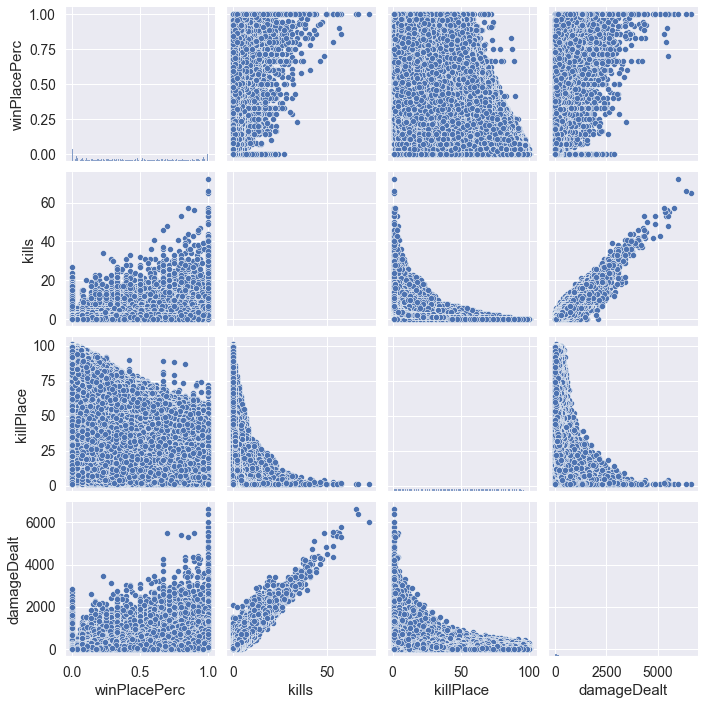

In [21]:
sns.pairplot(train[['winPlacePerc','kills', 'killPlace','damageDealt']]);

In [22]:
train[['winPlacePerc','killPlace']].corr()

,winPlacePerc,killPlace
winPlacePerc,1.000000,-0.719069
killPlace,-0.719069,1.000000


In [50]:
train = train.drop(['killPlace'], axis=1)

damageDealt

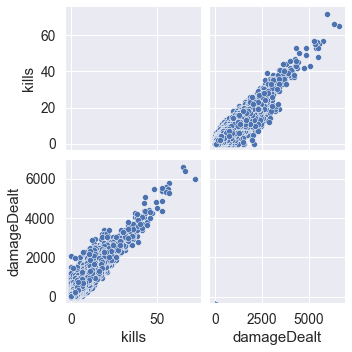

In [24]:
sns.pairplot(train[['kills','damageDealt']])

In [25]:
train[['kills','damageDealt']].corr()

,kills,damageDealt
kills,1.000000,0.888784
damageDealt,0.888784,1.000000


In [26]:
# train = train.drop(['damageDealt'], axis=1)

killPoints, rankPoints, winPoints

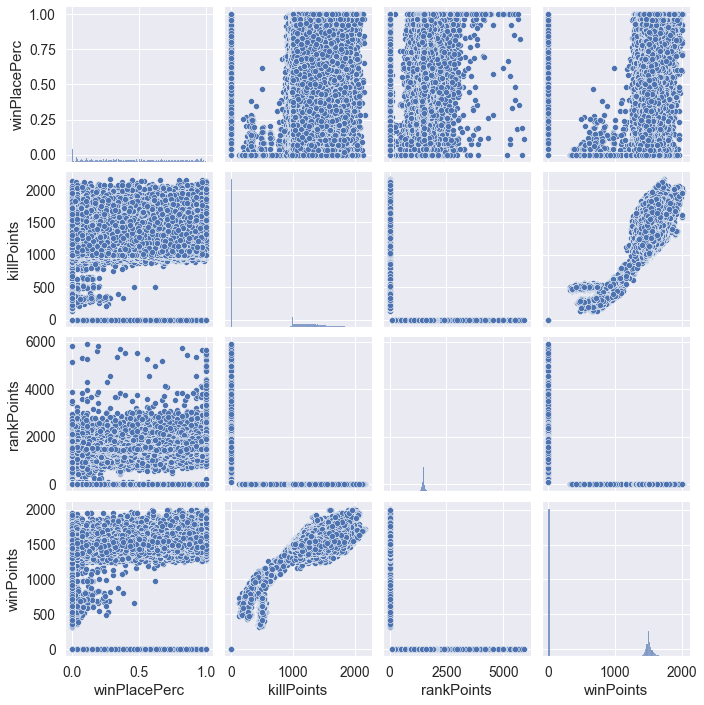

In [27]:
sns.pairplot(train[['winPlacePerc','killPoints','rankPoints','winPoints']]);

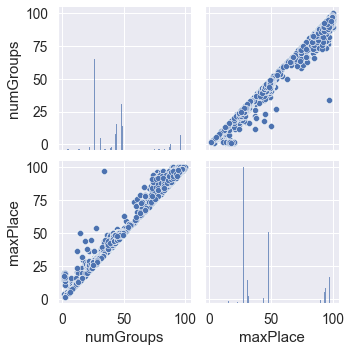

In [28]:
sns.pairplot(train[['numGroups','maxPlace']])

In [29]:
train[['winPlacePerc','killPoints','rankPoints','winPoints','numGroups','maxPlace']].corr()

,winPlacePerc,killPoints,rankPoints,winPoints,numGroups,maxPlace
winPlacePerc,1.000000,0.012909,0.013529,0.007062,0.039625,0.037381
killPoints,0.012909,1.000000,-0.975550,0.983417,-0.042367,-0.044802
rankPoints,0.013529,-0.975550,1.000000,-0.993840,0.047001,0.048717
winPoints,0.007062,0.983417,-0.993840,1.000000,-0.027483,-0.029295
numGroups,0.039625,-0.042367,0.047001,-0.027483,1.000000,0.997900
maxPlace,0.037381,-0.044802,0.048717,-0.029295,0.997900,1.000000


In [51]:
train = train.drop(['killPoints','rankPoints','winPoints'], axis=1)

In [52]:
train = train.drop(['numGroups','maxPlace'], axis=1)

assists, headshotKills, DBNOs, revives

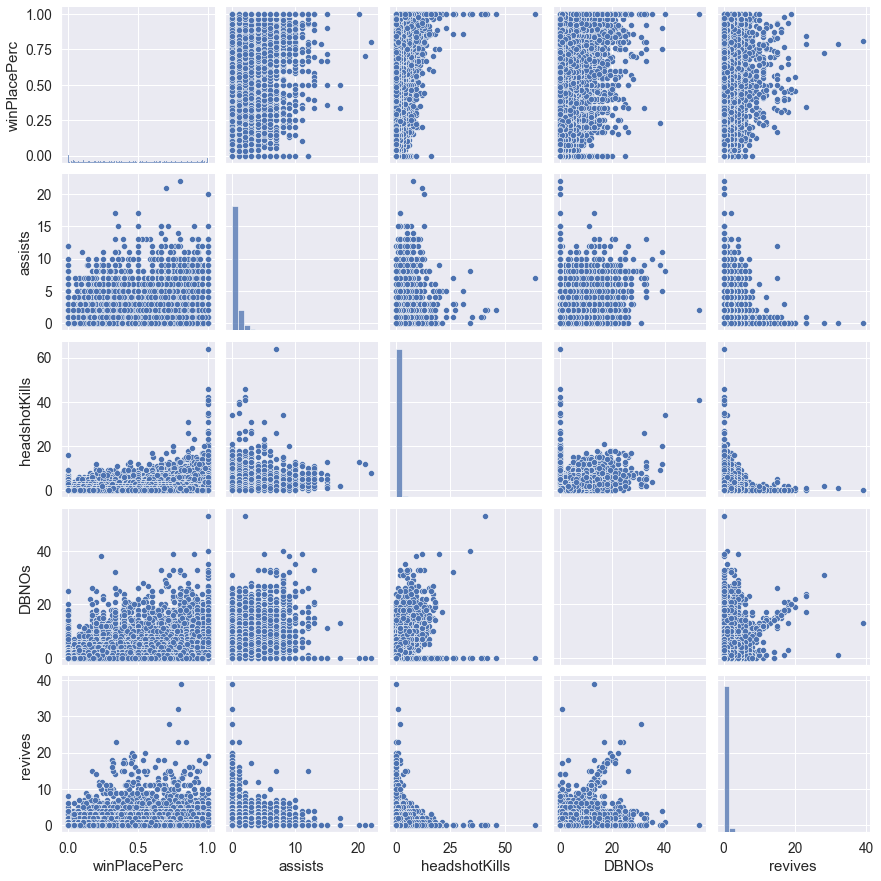

In [32]:
sns.pairplot(train[['winPlacePerc','assists','headshotKills','DBNOs','revives']])

In [33]:
train[['winPlacePerc','assists','headshotKills','DBNOs','revives']].corr()

,winPlacePerc,assists,headshotKills,DBNOs,revives
winPlacePerc,1.000000,0.299439,0.277722,0.279968,0.240880
assists,0.299439,1.000000,0.198289,0.301057,0.198320
headshotKills,0.277722,0.198289,1.000000,0.469923,0.150145
DBNOs,0.279968,0.301057,0.469923,1.000000,0.300999
revives,0.240880,0.198320,0.150145,0.300999,1.000000


In [34]:
# train = train.drop(['assists','headshotKills','DBNOs','revives'], axis=1)

In [35]:
train[['winPlacePerc','roadKills','teamKills']].corr()

,winPlacePerc,roadKills,teamKills
winPlacePerc,1.000000,0.034544,0.015942
roadKills,0.034544,1.000000,0.009684
teamKills,0.015942,0.009684,1.000000


matchDuration

In [53]:
train[['winPlacePerc','matchDuration']].corr()

,winPlacePerc,matchDuration
winPlacePerc,1.000000,-0.005171
matchDuration,-0.005171,1.000000


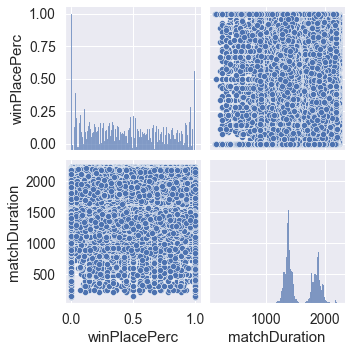

In [54]:
sns.pairplot(train[['winPlacePerc', 'matchDuration']])

In [55]:
train = train.drop(['matchDuration'], axis=1)

In [56]:
df_corr = train.corr()
df_corr = df_corr.apply(lambda x: round(x ,2))
df_corr = df_corr.unstack()
df_corr = pd.DataFrame(df_corr.winPlacePerc[df_corr.winPlacePerc < 1].sort_values(ascending=False), columns=['corr'])
df_corr.style.background_gradient(cmap='viridis')

,corr
walkDistance,0.810000
boosts,0.630000
weaponsAcquired,0.580000
damageDealt,0.440000
heals,0.430000
kills,0.420000
longestKill,0.410000
killStreaks,0.380000
rideDistance,0.340000
assists,0.300000


In [57]:
X = train.drop(["winPlacePerc"], axis=1)
y = train['winPlacePerc']

# 학습을 위한 training / test dataset 나누기
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0xC0FFEE)

# 6 : 2 : 2 = train : validation : test
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)
gc.collect()

(2668179, 18) (889393, 18) (889393, 18) (2668179,) (889393,) (889393,)


156

In [58]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [59]:
## training
reg = LinearRegression()
reg2 = Lasso()
reg3 = Ridge()
reg4 = XGBRegressor()
reg5 = LGBMRegressor()

reg.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)
reg4.fit(X_train, y_train)
reg5.fit(X_train, y_train)

pred_train = reg.predict(X_train)
pred_train2 = reg2.predict(X_train)
pred_train3 = reg3.predict(X_train)
pred_train4 = reg4.predict(X_train)
pred_train5 = reg5.predict(X_train)

pred_val = reg.predict(X_val)
pred_val2 = reg2.predict(X_val)
pred_val3 = reg3.predict(X_val)
pred_val4 = reg4.predict(X_val)
pred_val5 = reg5.predict(X_val)

mae_train = mean_absolute_error(y_train, pred_train)
mae_val = mean_absolute_error(y_val, pred_val)
mae_train2 = mean_absolute_error(y_train, pred_train2)
mae_val2 = mean_absolute_error(y_val, pred_val2)
mae_train3 = mean_absolute_error(y_train, pred_train3)
mae_val3 = mean_absolute_error(y_val, pred_val3)
mae_train4 = mean_absolute_error(y_train, pred_train4)
mae_val4 = mean_absolute_error(y_val, pred_val4)
mae_train5 = mean_absolute_error(y_train, pred_train5)
mae_val5 = mean_absolute_error(y_val, pred_val5)


print("1. Linear Regression\t, train=%.4f, val=%.4f" % (mae_train, mae_val))
print("2. Lasso\t\t, train=%.4f, val=%.4f" % (mae_train2, mae_val2))
print("3. Ridge\t\t, train=%.4f, val=%.4f" % (mae_train3, mae_val3))
print("4. XGBoost\t\t, train=%.4f, val=%.4f" % (mae_train4, mae_val4))
print("5. LightGBM\t\t, train=%.4f, val=%.4f" % (mae_train5, mae_val5))
gc.collect()

1. Linear Regression	, train=0.1256, val=0.1256
2. Lasso		, train=0.2679, val=0.2678
3. Ridge		, train=0.1256, val=0.1256
4. XGBoost		, train=0.0975, val=0.0979
5. LightGBM		, train=0.0982, val=0.0982


54

In [60]:
# prediction!
result = reg.predict(X_test)
result2 = reg2.predict(X_test)
result3 = reg3.predict(X_test)
result4 = reg4.predict(X_test)
result5 = reg5.predict(X_test)
gc.collect()

4

In [61]:
# Summary!
print("---------- Linear Regression ---------")
print('MAE in training: %.4f' % mean_absolute_error(y_test, result))

print("---------- Lasso ---------")
print('MAE in training: %.4f' % mean_absolute_error(y_test, result2))

print("---------- Ridge ---------")
print('MAE in training: %.4f' % mean_absolute_error(y_test, result3))

print("---------- XGBoost ---------")
print('MAE in training: %.4f' % mean_absolute_error(y_test, result4))

print("---------- LightGBM ---------")
print('MAE in training: %.4f' % mean_absolute_error(y_test, result5))

---------- Linear Regression ---------
MAE in training: 0.1255
---------- Lasso ---------
MAE in training: 0.2681
---------- Ridge ---------
MAE in training: 0.1256
---------- XGBoost ---------
MAE in training: 0.0978
---------- LightGBM ---------
MAE in training: 0.0981


0

### Hyper-parameter tuning

1. Human Search
2. Grid Search(GridSearchCV) : 주어진 hp의 조합을 모두 돌려보는 방식.
3. Bayesian Optimization(hyperopt, optuna, ...) : hyper-parameter를 최적화하는 베이지안 방식을 사용.

In [ ]:
# # GridSearchCV
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "max_depth" : [3, 4, 5, 6, 7, -1], # 6
#     "learning_rate" : [0.1, 0.01, 0.05], # 3
#     "n_estimators" : [50, 100, 200] # 3
# } # 6x3x3 = 54

# gcv = GridSearchCV(reg5, param_grid, scoring='neg_mean_absolute_error', verbose=1)
# gcv.fit(X_train, y_train)
# print(gcv.cv_results_)
# print(gcv.best_estimator_)
# print(gcv.best_params_)

In [ ]:
# training set과 같은 전처리! V
# final_model = gcv.best_estimator_

--------

In [ ]:
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb

#print("Read Done")
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df





def featureModify(isTrain):
    if isTrain:
        all_data = pd.read_csv('./data/pubg-finish-placement-prediction/train_V2.csv') 
        all_data = all_data[all_data['maxPlace'] > 1]
        all_data = reduce_mem_usage(all_data)
        all_data = all_data[all_data['winPlacePerc'].notnull()]
    else:
        all_data = pd.read_csv('./data/pubg-finish-placement-prediction/test_V2.csv')


    all_data['matchType'] = all_data['matchType'].map({
    'crashfpp':1,
    'crashtpp':2,
    'duo':3,
    'duo-fpp':4,
    'flarefpp':5,
    'flaretpp':6,
    'normal-duo':7,
    'normal-duo-fpp':8,
    'normal-solo':9,
    'normal-solo-fpp':10,
    'normal-squad':11,
    'normal-squad-fpp':12,
    'solo':13,
    'solo-fpp':14,
    'squad':15,
    'squad-fpp':16
    })
    all_data = reduce_mem_usage(all_data)

    print("Match size")
    matchSizeData = all_data.groupby(['matchId']).size().reset_index(name='matchSize')
    all_data = pd.merge(all_data, matchSizeData, how='left', on=['matchId'])
    del matchSizeData
    gc.collect()
    
    
    all_data.loc[(all_data['rankPoints']==-1), 'rankPoints'] = 0
    all_data['_killPoints_rankpoints'] = all_data['rankPoints']+all_data['killPoints']


    all_data["_Kill_headshot_Ratio"] = all_data["kills"]/all_data["headshotKills"]
    all_data['_killStreak_Kill_ratio'] = all_data['killStreaks']/all_data['kills']
    all_data['_totalDistance'] = 0.25*all_data['rideDistance'] + all_data["walkDistance"] + all_data["swimDistance"]
    all_data['_killPlace_MaxPlace_Ratio'] = all_data['killPlace'] / all_data['maxPlace']
    all_data['_totalDistance_weaponsAcq_Ratio'] = all_data['_totalDistance'] / all_data['weaponsAcquired']
    all_data['_walkDistance_heals_Ratio'] = all_data['walkDistance'] / all_data['heals']
    all_data['_walkDistance_kills_Ratio'] = all_data['walkDistance'] / all_data['kills']
    all_data['_kills_walkDistance_Ratio'] = all_data['kills'] / all_data['walkDistance']
    all_data['_totalDistancePerDuration'] =  all_data["_totalDistance"]/all_data["matchDuration"]
    all_data['_killPlace_kills_Ratio'] = all_data['killPlace']/all_data['kills']
    all_data['_walkDistancePerDuration'] =  all_data["walkDistance"]/all_data["matchDuration"]
    all_data['walkDistancePerc'] = all_data.groupby('matchId')['walkDistance'].rank(pct=True).values
    all_data['killPerc'] = all_data.groupby('matchId')['kills'].rank(pct=True).values
    all_data['killPlacePerc'] = all_data.groupby('matchId')['killPlace'].rank(pct=True).values
    all_data['weaponsAcquired'] = all_data.groupby('matchId')['weaponsAcquired'].rank(pct=True).values
    all_data['_walkDistance_kills_Ratio2'] = all_data['walkDistancePerc'] / all_data['killPerc']
    all_data['_kill_kills_Ratio2'] = all_data['killPerc']/all_data['walkDistancePerc']
    all_data['_killPlace_walkDistance_Ratio2'] = all_data['walkDistancePerc']/all_data['killPlacePerc']
    all_data['_killPlace_kills_Ratio2'] = all_data['killPlacePerc']/all_data['killPerc']
    all_data['_totalDistance'] = all_data.groupby('matchId')['_totalDistance'].rank(pct=True).values
    all_data['_walkDistance_kills_Ratio3'] = all_data['walkDistancePerc'] / all_data['kills']
    all_data['_walkDistance_kills_Ratio4'] = all_data['kills'] / all_data['walkDistancePerc']
    all_data['_walkDistance_kills_Ratio5'] = all_data['killPerc'] / all_data['walkDistance']
    all_data['_walkDistance_kills_Ratio6'] = all_data['walkDistance'] / all_data['killPerc']

    all_data[all_data == np.Inf] = np.NaN
    all_data[all_data == np.NINF] = np.NaN
    all_data.fillna(0, inplace=True)
    
    features = list(all_data.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchSize")
    features.remove("matchType")
    if isTrain:
        features.remove("winPlacePerc")

    
    print("Mean Data")
    meanData = all_data.groupby(['matchId','groupId'])[features].agg('mean')
    meanData = reduce_mem_usage(meanData)
    meanData = meanData.replace([np.inf, np.NINF,np.nan], 0)
    meanDataRank = meanData.groupby('matchId')[features].rank(pct=True).reset_index()
    meanDataRank = reduce_mem_usage(meanDataRank)
    all_data = pd.merge(all_data, meanData.reset_index(), suffixes=["", "_mean"], how='left', on=['matchId', 'groupId'])
    del meanData
    gc.collect()
    all_data = all_data.drop(["vehicleDestroys_mean","rideDistance_mean","roadKills_mean","rankPoints_mean"], axis=1)
    all_data = pd.merge(all_data, meanDataRank, suffixes=["", "_meanRank"], how='left', on=['matchId', 'groupId'])
    del meanDataRank
    gc.collect()
    all_data = all_data.drop(["numGroups_meanRank","rankPoints_meanRank"], axis=1)
    
    all_data = all_data.join(reduce_mem_usage(all_data.groupby('matchId')[features].rank(ascending=False).add_suffix('_rankPlace').astype(int)))

    
    print("Std Data")
    stdData = all_data.groupby(['matchId','groupId'])[features].agg('std').replace([np.inf, np.NINF,np.nan], 0)
    stdDataRank = reduce_mem_usage(stdData.groupby('matchId')[features].rank(pct=True)).reset_index()
    del stdData
    gc.collect()
    all_data = pd.merge(all_data, stdDataRank, suffixes=["", "_stdRank"], how='left', on=['matchId', 'groupId'])
    del stdDataRank
    gc.collect()
    
    print("Max Data")
    maxData = all_data.groupby(['matchId','groupId'])[features].agg('max')
    maxData = reduce_mem_usage(maxData)
    maxDataRank = maxData.groupby('matchId')[features].rank(pct=True).reset_index()
    maxDataRank = reduce_mem_usage(maxDataRank)
    all_data = pd.merge(all_data, maxData.reset_index(), suffixes=["", "_max"], how='left', on=['matchId', 'groupId'])
    del maxData
    gc.collect()
    all_data = all_data.drop(["assists_max","killPoints_max","headshotKills_max","numGroups_max","revives_max","teamKills_max","roadKills_max","vehicleDestroys_max"], axis=1)
    all_data = pd.merge(all_data, maxDataRank, suffixes=["", "_maxRank"], how='left', on=['matchId', 'groupId'])
    del maxDataRank
    gc.collect()
    all_data = all_data.drop(["roadKills_maxRank","matchDuration_maxRank","maxPlace_maxRank","numGroups_maxRank"], axis=1)


    print("Min Data")
    minData = all_data.groupby(['matchId','groupId'])[features].agg('min')
    minData = reduce_mem_usage(minData)
    minDataRank = minData.groupby('matchId')[features].rank(pct=True).reset_index()
    minDataRank = reduce_mem_usage(minDataRank)
    all_data = pd.merge(all_data, minData.reset_index(), suffixes=["", "_min"], how='left', on=['matchId', 'groupId'])
    del minData
    gc.collect()
    all_data = all_data.drop(["heals_min","killStreaks_min","killPoints_min","maxPlace_min","revives_min","headshotKills_min","weaponsAcquired_min","_walkDistance_kills_Ratio_min","rankPoints_min","matchDuration_min","teamKills_min","numGroups_min","assists_min","roadKills_min","vehicleDestroys_min"], axis=1)
    all_data = pd.merge(all_data, minDataRank, suffixes=["", "_minRank"], how='left', on=['matchId', 'groupId'])
    del minDataRank
    gc.collect()
    all_data = all_data.drop(["killPoints_minRank","matchDuration_minRank","maxPlace_minRank","numGroups_minRank"], axis=1)

    
    print("group Size")
    groupSize = all_data.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    groupSize = reduce_mem_usage(groupSize)
    all_data = pd.merge(all_data, groupSize, how='left', on=['matchId', 'groupId'])
    del groupSize
    gc.collect()

    
    print("Match Mean")
    matchMeanFeatures = features
    matchMeanFeatures = [ v for v in matchMeanFeatures if v not in ["killPlacePerc","matchDuration","maxPlace","numGroups"] ]
    matchMeanData= reduce_mem_usage(all_data.groupby(['matchId'])[matchMeanFeatures].transform('mean')).replace([np.inf, np.NINF,np.nan], 0)
    all_data = pd.concat([all_data,matchMeanData.add_suffix('_matchMean')],axis=1)
    del matchMeanData,matchMeanFeatures
    gc.collect()

    print("matchMax")
    matchMaxFeatures = ["walkDistance","kills","_walkDistance_kills_Ratio","_kill_kills_Ratio2"]
    all_data = pd.merge(all_data, reduce_mem_usage(all_data.groupby(['matchId'])[matchMaxFeatures].agg('max')).reset_index(), suffixes=["", "_matchMax"], how='left', on=['matchId'])

    print("match STD")
    matchMaxFeatures = ["kills","_walkDistance_kills_Ratio2","_walkDistance_kills_Ratio","killPerc","_kills_walkDistance_Ratio"]
    all_data = pd.merge(all_data, reduce_mem_usage(all_data.groupby(['matchId'])[matchMaxFeatures].agg('std')).reset_index().replace([np.inf, np.NINF,np.nan], 0), suffixes=["", "_matchSTD"], how='left', on=['matchId'])


    all_data = all_data.drop(["Id","groupId"], axis=1)
    all_data = all_data.drop(["DBNOs","assists","headshotKills","heals","killPoints","_killStreak_Kill_ratio","killStreaks","longestKill","revives","roadKills","teamKills","vehicleDestroys","_walkDistance_kills_Ratio","weaponsAcquired"], axis=1)
    all_data = all_data.drop(["_walkDistance_heals_Ratio","_totalDistancePerDuration","_killPlace_kills_Ratio","_totalDistance_weaponsAcq_Ratio","_killPlace_MaxPlace_Ratio","_walkDistancePerDuration","rankPoints","rideDistance","boosts","winPoints","swimDistance","_kills_walkDistance_Ratio"], axis=1)
    all_data = all_data.drop(["_Kill_headshot_Ratio","maxPlace","_totalDistance","numGroups","walkDistance","killPlace"], axis=1)
    all_data = reduce_mem_usage(all_data)
    gc.collect()
    
    print("done")
    features_label = all_data.columns
    features_label = features_label.drop('matchId')
    if isTrain:
        features_label = features_label.drop('winPlacePerc')

    gc.collect()
    return all_data,features_label
    
X_train,features_label = featureModify(True) 

print("Split time")
def split_train_val(data, fraction):
    matchIds = data['matchId'].unique().reshape([-1])
    train_size = int(len(matchIds)*fraction)
    
    random_idx = np.random.RandomState(seed=2).permutation(len(matchIds))
    train_matchIds = matchIds[random_idx[:train_size]]
    val_matchIds = matchIds[random_idx[train_size:]]
    
    data_train = data.loc[data['matchId'].isin(train_matchIds)]
    data_val = data.loc[data['matchId'].isin(val_matchIds)]
    return data_train, data_val

# Split the Data by matchId. Thanks to Ivan Batalov for this. 
X_train, X_train_test = split_train_val(X_train, 0.91)
print("Y time")
y = X_train['winPlacePerc']
y_test = X_train_test['winPlacePerc']
print("X_train time")
X_train = X_train.drop(columns=['matchId', 'winPlacePerc'])
print("X test train time")
X_train_test = X_train_test.drop(columns='matchId')
print("X test train winPlace remove")
X_train_test = X_train_test.drop(columns='winPlacePerc')

print("X test np time")
X_train_test = np.array(X_train_test)
print("y test np time")
y_test = np.array(y_test)

#Split the Data again and then join it. I am doing this because If I turn the Pandas DataFrame into Numpy Array with 
# all rows at once, Kernel will be killed for exceeding 16GB Memory. 
from sklearn.model_selection import train_test_split
X_train, X_train2, y, y2 = train_test_split(X_train, y, test_size=0.1, shuffle=False)
print("X_train np time")
X_train = np.array(X_train)
print("y np time")
y = np.array(y)

print("X_train2 np time")
X_train2 = np.array(X_train2)
print("y2 np time")
y2 = np.array(y2)

y = np.concatenate((y, y2), axis=0)
del y2
gc.collect()
X_train = np.concatenate((X_train, X_train2), axis=0)
del X_train2
gc.collect()


train_set = lgb.Dataset(X_train, label=y)
del X_train,y
gc.collect()
valid_set = lgb.Dataset(X_train_test, label=y_test)
del X_train_test,y_test
gc.collect()

params = {
        "objective" : "regression", 
        "metric" : "mae", 
        "num_leaves" : 149, 
        "learning_rate" : 0.03, 
        "bagging_fraction" : 0.9,
        "bagging_seed" : 0, 
        "num_threads" : 4,
        "colsample_bytree" : 0.5,
        'min_data_in_leaf':1900, 
        'min_split_gain':0.00011,
        'lambda_l2':9
}

model = lgb.train(  params, 
                    train_set = train_set,
                    num_boost_round=9400,
                    early_stopping_rounds=200,
                    verbose_eval=100, 
                    valid_sets=[train_set,valid_set]
                  )
  
del train_set,valid_set
gc.collect()
                
print("Calculating Feature Importance and save it in a file") 
featureImp = list(model.feature_importance())
featureImp, features_label = zip(*sorted(zip(featureImp, features_label)))
with open("FeatureImportance.txt", "w") as text_file:
    for i in range(len(featureImp)):
        print(f"{features_label[i]} =  {featureImp[i]}", file=text_file)

print("Done calculating")
del featureImp,features_label
gc.collect()

                  
X_test,features_label = featureModify(False) 
X_test = X_test.drop(columns=['matchId'])
X_test = np.array(X_test)
y_pred=model.predict(X_test, num_iteration=model.best_iteration)
del X_test
gc.collect()

# Insert ID and Predictions into dataframe
df_sub = pd.DataFrame()

df_test = pd.read_csv('./data/pubg-finish-placement-prediction/test_V2.csv'')
df_test = reduce_mem_usage(df_test)
df_sub['Id'] = df_test['Id']
df_sub['winPlacePerc'] = y_pred

print(df_sub['winPlacePerc'].describe())


df_sub = df_sub.merge(df_test[["Id", "matchId", "groupId", "maxPlace", "numGroups"]], on="Id", how="left")
df_sub_group = df_sub.groupby(["matchId", "groupId"]).first().reset_index()
df_sub_group["rank"] = df_sub_group.groupby(["matchId"])["winPlacePerc"].rank()
df_sub_group = df_sub_group.merge(
    df_sub_group.groupby("matchId")["rank"].max().to_frame("max_rank").reset_index(), 
    on="matchId", how="left")
df_sub_group["adjusted_perc"] = (df_sub_group["rank"] - 1) / (df_sub_group["numGroups"] - 1)
df_sub = df_sub.merge(df_sub_group[["adjusted_perc", "matchId", "groupId"]], on=["matchId", "groupId"], how="left")
df_sub["winPlacePerc"] = df_sub["adjusted_perc"]


df_sub.loc[df_sub.maxPlace == 0, "winPlacePerc"] = 0
df_sub.loc[df_sub.maxPlace == 1, "winPlacePerc"] = 1
subset = df_sub.loc[df_sub.maxPlace > 1]
gap = 1.0 / (subset.maxPlace.values - 1)
new_perc = np.around(subset.winPlacePerc.values / gap) * gap
df_sub.loc[df_sub.maxPlace > 1, "winPlacePerc"] = new_perc
# Edge case
df_sub.loc[(df_sub.maxPlace > 1) & (df_sub.numGroups == 1), "winPlacePerc"] = 0
assert df_sub["winPlacePerc"].isnull().sum() == 0

df_sub[["Id", "winPlacePerc"]].to_csv("submission.csv", index=False)
print(df_sub['winPlacePerc'].describe())

